In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

# Display the version
print(tf.__version__)

# import and mount Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

2.13.0
Mounted at /content/gdrive


In [ ]:
# get path to folder file is in
file_path = '/content/gdrive/MyDrive/apstats-experimentproject'
print(file_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
/content/gdrive/My Drive/Personal Projects/Pioneer Academics Research/code/CIFAR-10


In [ ]:
# Download the data from tf, unless it's already here.
if not os.path.exists(file_path+'/data/clean'):
  os.mkdir(file_path+'/data/clean')
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
  np.save(file_path+'/data/clean/X_train.npy',X_train)
  np.save(file_path+'/data/clean/y_train.npy',y_train)
  np.save(file_path+'/data/clean/X_test.npy',X_test)
  np.save(file_path+'/data/clean/y_test.npy',y_test)
else:
  X_train = np.load(file_path+'/data/clean/X_train.npy')
  y_train = np.load(file_path+'/data/clean/y_train.npy')
  X_test = np.load(file_path+'/data/clean/X_test.npy')
  y_test = np.load(file_path+'/data/clean/y_test.npy')

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [ ]:
# Convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Decrease pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Load in Clean Model
model = tf.keras.models.load_model(file_path+'/models/clean.keras')

In [ ]:
# Create FGSM Perturbed Data
def create_fgsm_perturbations(data_inputs, data_labels, epsilon = 0.1):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output_tensor = model(input_tensor)
    loss = loss_fn(label_tensor, output_tensor)

  gradient = tape.gradient(loss, input_tensor)
  perturbed_input_tensor = input_tensor + epsilon * tf.sign(gradient)
  return tf.cast(perturbed_input_tensor, dtype=input_tensor.dtype)

# Create FGSM perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/FGSM_perturbed'):
  os.mkdir(file_path+'/data/FGSM_perturbed')

  perturbed_data = [None for _ in range(5)]
  for i in range(5):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_FGSM_train = np.concatenate(perturbed_data, axis=0)
  X_FGSM_test = create_fgsm_perturbations(X_test, y_test)

  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy',X_FGSM_train)
  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy',X_FGSM_test)
else:
  X_FGSM_train = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy')
  X_FGSM_test = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy')

print("X_FGSM_train shape", X_FGSM_train.shape)
print("y_train shape", y_train.shape)
print("X_FGSM_test shape", X_FGSM_test.shape)
print("y_test shape", y_test.shape)

X_FGSM_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_FGSM_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [ ]:
# Clip perturbed training and test data to viable values
X_FGSM_train = np.clip(X_FGSM_train, a_min = 0.0, a_max = 1.0)
X_FGSM_test = np.clip(X_FGSM_test, a_min = 0.0, a_max = 1.0)

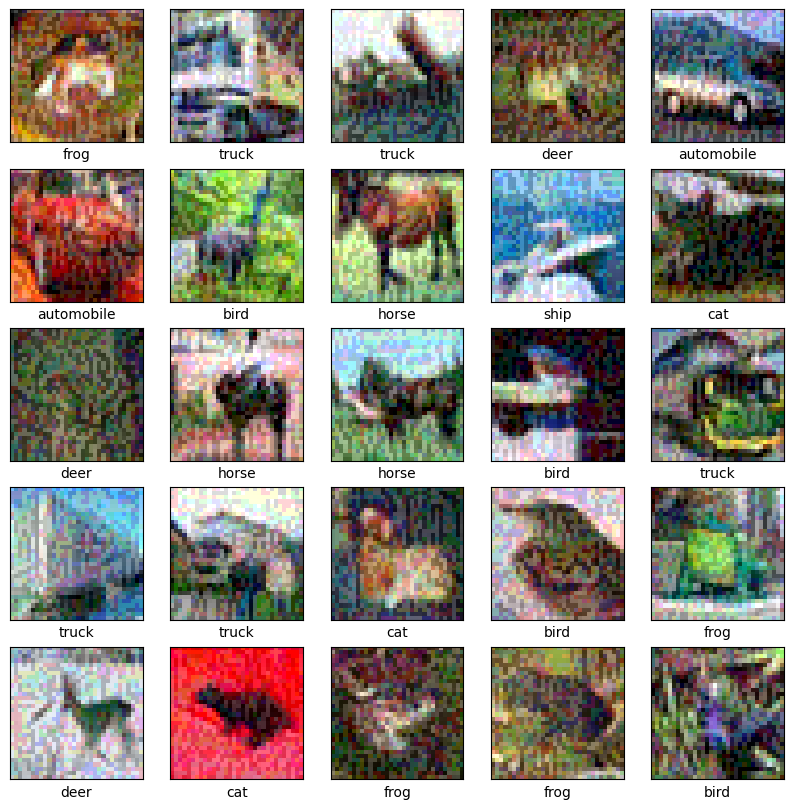

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_FGSM_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [ ]:
model.evaluate(X_FGSM_train, y_train)
model.evaluate(X_FGSM_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 6.7091 - accuracy: 0.0394


[6.709075927734375, 0.039400000125169754]

In [ ]:
# Create PGD Perturbed Data
def create_pgd_perturbations(data_inputs, data_labels, epsilon = 0.01, n_iter = 10):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

  perturbed_tensor = input_tensor
  for i in range(n_iter):
      with tf.GradientTape() as tape:
          tape.watch(perturbed_tensor)
          output_tensor = model(perturbed_tensor)
          loss = loss_fn(label_tensor, output_tensor)

      gradient = tape.gradient(loss, perturbed_tensor)

      perturbed_tensor = perturbed_tensor + gradient
      # Project perturbed_tensor onto the L-infinity ball around input_tensor
      perturbed_tensor = epsilon * tf.sign(
          perturbed_tensor - input_tensor) + input_tensor

  perturbed_tensor = tf.cast(perturbed_tensor, dtype=input_tensor.dtype)
  return perturbed_tensor

# Create PGD perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/PGD_perturbed'):
  os.mkdir(file_path+'/data/PGD_perturbed')

  perturbed_data = [None for _ in range(5)]
  for i in range(5):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_PGD_train = np.concatenate(perturbed_data, axis=0)
  X_PGD_test = create_pgd_perturbations(X_test, y_test)

  np.save(file_path+'/data/PGD_perturbed/X_PGD_train.npy',X_PGD_train)
  np.save(file_path+'/data/PGD_perturbed/X_PGD_test.npy',X_PGD_test)
else:
  X_PGD_train = np.load(file_path+'/data/PGD_perturbed/X_PGD_train.npy')
  X_PGD_test = np.load(file_path+'/data/PGD_perturbed/X_PGD_test.npy')

print("X_PGD_train shape", X_PGD_train.shape)
print("y_train shape", y_train.shape)
print("X_PGD_test shape", X_PGD_test.shape)
print("y_test shape", y_test.shape)

X_PGD_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_PGD_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [ ]:
# Clip perturbed training and test data to viable values
X_PGD_train = np.clip(X_PGD_train, a_min = 0.0, a_max = 1.0)
X_PGD_test = np.clip(X_PGD_test, a_min = 0.0, a_max = 1.0)

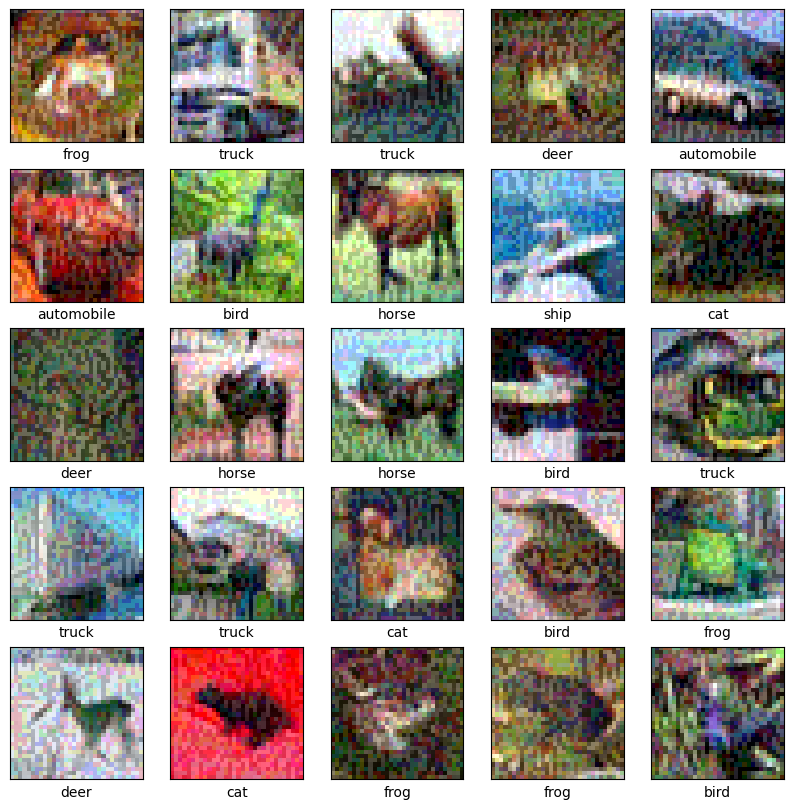

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_PGD_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [ ]:
model.evaluate(X_PGD_train, y_train)
model.evaluate(X_PGD_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.9631 - accuracy: 0.3434


[2.9630656242370605, 0.3434000015258789]

In [ ]:
# Combining datasets to get equal amount of clean and adversarial data in each batch
def combine_datasets(adversarial_data, clean_data=X_train, data_labels=y_train, batch_size=32):
  n_iters = int(2 * clean_data.shape[0] / batch_size) + 1
  mixed_dataset = [None for _ in range(n_iters)]
  mixed_labels = [None for _ in range(n_iters)]
  for i in range(n_iters):
    start_index = int(i * batch_size/2)
    end_index = min(clean_data.shape[0], int((i+1) * batch_size/2))
    mixed_dataset[i] = np.concatenate([clean_data[start_index:end_index], adversarial_data[start_index:end_index]], axis=0)
    mixed_labels[i] = np.concatenate([data_labels[start_index:end_index], data_labels[start_index:end_index]], axis=0)
  final_dataset = np.concatenate(mixed_dataset, axis=0)
  final_labels = np.concatenate(mixed_labels, axis=0)
  return final_dataset, final_labels

In [ ]:
# Implement the chosen values in a final model
def train(params=[64, 64, 128, 128, 256, 256], X_used_train = X_train, y_used_train = y_train, file_name=(file_path + '/models/perturbed.keras'), num_epochs = 50, lr = 0.0003, drop = 0.2, reg = 1e-4, batch_size=32):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(params[0], (3, 3), input_shape=X_used_train.shape[1:], padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(drop))

    model.add(tf.keras.layers.Conv2D(params[1], (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(drop))
    model.add(tf.keras.layers.Conv2D(params[2], (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(drop))
    model.add(tf.keras.layers.Conv2D(params[3], (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(drop))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(params[4], activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(tf.keras.layers.Dropout(drop))
    model.add(tf.keras.layers.Dense(params[5], activation='relu', kernel_regularizer=tf.keras.regularizers.L2(reg)))
    model.add(tf.keras.layers.Dropout(drop))
    model.add(tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(reg)))

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])

    model.summary()

    model.fit(X_used_train, y_used_train,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=num_epochs,
              shuffle=True,
              verbose=1)

    if file_name != None:
        model.save(file_name)

    return model

In [ ]:
X_mixed_FGSM_train, y_mixed_FGSM_train = combine_datasets(X_FGSM_train)

# Check that the resulting dataset's shape is correct
print(X_mixed_FGSM_train.shape)
print(y_mixed_FGSM_train.shape)

# Validate that the mixed data at least sort of works
model.evaluate(X_mixed_FGSM_train, y_mixed_FGSM_train)

# Clear up some variables
del X_FGSM_train

(100000, 32, 32, 3)
(100000, 1)
3125/3125 [==============================] - 9s 3ms/step - loss: 3.3409 - accuracy: 0.4971


In [ ]:
FGSM_model = train(X_used_train = X_mixed_FGSM_train, y_used_train = y_mixed_FGSM_train, file_name = (file_path + '/models/mixed_FGSM.keras'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0

In [ ]:
# Evaluate it on a set the model has never seen
FGSM_model.evaluate(X_FGSM_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7698 - accuracy: 0.8128


[0.7697712779045105, 0.8127999901771545]

In [ ]:
# Clear up some variables
del X_mixed_FGSM_train
del y_mixed_FGSM_train

In [ ]:
X_mixed_PGD_train, y_mixed_PGD_train = combine_datasets(X_PGD_train)

# Check that the resulting dataset's shape is correct
print(X_mixed_PGD_train.shape)
print(y_mixed_PGD_train.shape)

# Validate that the mixed data at least sort of works
model.evaluate(X_mixed_PGD_train, y_mixed_PGD_train)

# Clear up some variables
del X_PGD_train

(100000, 32, 32, 3)
(100000, 1)
3125/3125 [==============================] - 9s 3ms/step - loss: 3.3409 - accuracy: 0.4971


In [ ]:
PGD_model = train(X_used_train = X_mixed_PGD_train, y_used_train = y_mixed_PGD_train, file_name = (file_path + '/models/mixed_PGD.keras'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 64)         

In [ ]:
# Evaluate it on a set the model has never seen
PGD_model.evaluate(X_PGD_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0162 - accuracy: 0.7270


[1.0162084102630615, 0.7269999980926514]

In [ ]:
# Clear up some variables
del X_mixed_PGD_train
del y_mixed_PGD_train

In [ ]:
# Clear up some variables
del X_train
del y_train